Design and conduct an experiment to empirically investigate, for the   given class of functions $f=g+h$ (quadratic plus $\ell_1$), the use of exact
steps sizes in coordinate proximal gradient descent.  That is, we know (from parts (c) and (d)) that coordinate descent is the same as using exact line
search at each step of coordinate proximal gradient descent; how much does this help over fixed step sizes, or backtracking line search?  


Some general tips: be completely explicit about all your experimental design choices; think in particular about the problem conditioning; use figures rather than tables to report what you find; aggregate results over multiple simulation  instances. 

In [2]:
import numpy as np
import scipy.optimize
lamda = 1
nr_vars = 19

In [3]:
def g(x):
    return x.T@Q@x/2.-b@x
def nabla_g(x):
    return Q@x-b
def h(x, lamda):
    return lamda*np.sum(np.abs(x))

In [4]:
def prox_h(x, t, lamda):
    return np.sign(x)*np.maximum(0,np.abs(x)-t*lamda)

In [5]:
def update_x(x, i, t, lamda):
    x_prime = prox_h(x[i] - t*nabla_g(x)[i], t, lamda)
    x_copy = x.copy()
    x_copy[i] = x_prime
    return x_copy

# the dirty function
def func_to_optimize_t(x, i, t, lamda):
    x_copy = update_x(x, i, t, lamda)
    val = g(x_copy)+h(x_copy, lamda)
    # print('eval t=',t, 'val=', val)
    return val

In [26]:
def backtrack_proximal_update(x, i, lamda, t, shrinkage):
    total_cnt = 0
    gb = g(x)
    ngb = nabla_g(x)
    while True:
        total_cnt += 1
        new_x = update_x(x, i, t, lamda)
        G = (x-new_x)/t
        lhs = g(new_x)
        rhs = gb - t*np.dot(ngb, G) + t/2*np.dot(G, G)
        #print(lhs, rhs)
        if lhs > rhs:
            # print('shrinkage happen!')
            t = shrinkage * t
        else:
            return new_x, total_cnt

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

In [70]:
# setup
A = np.random.randn(nr_vars, nr_vars)
Q = A.T@A
b = np.random.randn(nr_vars)
x0 = np.random.randn(nr_vars)

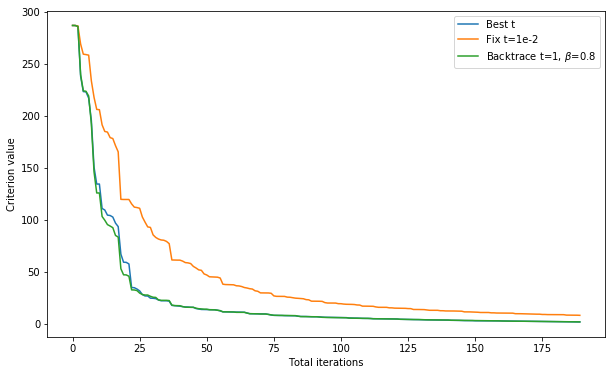

In [71]:

x_best = x0
x_fix = x0
x_backtrace = x0

f_best_arr = []
f_fix_arr = []
f_backtrace_arr = []
cnt_backtrace_arr = []

max_iter = 10

for idx_iter in range(max_iter):
    # inner (coordinate) loop
    for idx_coord in range(nr_vars):
        # show that any disturb make the function value higher
        f_best = g(x_best)+h(x_best,lamda)
        x_best = update_x(x_best, idx_coord, 1/Q[idx_coord, idx_coord], lamda)
        
        f_fix = g(x_fix)+h(x_fix,lamda)
        x_fix = update_x(x_fix, idx_coord, 1e-2, lamda)
        
        f_backtrace = g(x_backtrace)+h(x_backtrace,lamda)
        x_backtrace, backtrack_cnt = backtrack_proximal_update(x_backtrace, idx_coord, 1, lamda, shrinkage=0.8)
        cnt_backtrace_arr.append(backtrack_cnt)
        
        f_best_arr.append(f_best)
        f_fix_arr.append(f_fix)
        f_backtrace_arr.append(f_backtrace)

cnt_backtrace_arr = np.cumsum(cnt_backtrace_arr)
        
plt.figure(figsize=(10,6))
plt.plot(range(nr_vars*max_iter), f_best_arr, label='Best t')
plt.plot(range(nr_vars*max_iter), f_fix_arr, label='Fix t=1e-2')
# plt.plot(cnt_backtrace_arr, f_backtrace_arr, label='Backtrace t=0.1, $\\beta$=0.8')
# plt.xlabel('Total call to proximal op')
plt.plot(range(nr_vars*max_iter), f_backtrace_arr, label='Backtrace t=1, $\\beta$=0.8')
plt.xlabel('Total iterations')
plt.ylabel('Criterion value')
plt.legend()